## Pneumonia X-ray image analysis

In [111]:
%matplotlib inline 
import os
import tensorflow as tf
import numpy as np
from datetime import datetime
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, losses, metrics, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("tensorflow", tf.__version__)

tensorflow 2.18.0


In [112]:
# Training settings
batch_size = 128
img_height = 128
img_width = 128

## Data

In [113]:
train_dir = 'train'
test_dir = 'test'
# val_dir = 'chest_xray/val'

# Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed = 123,
  image_size = (img_height, img_width),
  batch_size = batch_size)

# Test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 4616 files belonging to 2 classes.
Using 3693 files for training.
Found 4616 files belonging to 2 classes.
Using 923 files for validation.
Found 623 files belonging to 2 classes.


Seuraavassa blokissa haetaan kuvat alihakemistosta.

Funktio palauttaa:

train_label_count: luokkien lukumäärä
train_label_names: luokkien nimet
train_data: luetut kuvat listana matriiseina xdim*ydim
train_labels: numeroidut labelit listana


In [114]:
import cv2
import os
import glob
import gc

def lire_images(img_dir, xdim, ydim, nmax=5000) :
    """ 
    Lit les images dans les sous répertoires de img_dir
    nmax images lues dans chaque répertoire au maximum
    Renvoie :
    X : liste des images lues, matrices xdim*ydim
    y : liste des labels numériques
    label : nombre de labels
    label_names : liste des noms des répertoires lus
    """
    label = 0
    label_names = []
    X = []
    y=[]
    for dirname in os.listdir(img_dir):
        print(dirname)
        label_names.append(dirname)
        data_path = os.path.join(img_dir + "/" + dirname,'*g')
        files = glob.glob(data_path)
        n=0
        for f1 in files:
            if n>nmax : break
            img = cv2.imread(f1) # Lecture de l'image dans le repertoire
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Conversion couleur RGB
            img = cv2.resize(img, (xdim,ydim)) # Redimensionnement de l'image
            X.append(np.array(img)) # Conversion en tableau et ajout a la liste des images
            y.append(label) # Ajout de l'etiquette de l'image a la liste des etiquettes
            n=n+1
        print(n,' images lues')
        label = label+1
    X = np.array(X)
    y = np.array(y)
    gc.collect() # Récupération de mémoire
    return X,y, label, label_names

# def lire_images(img_dir, xdim, ydim, nmax=5000) :
#     train_label_count = 0
#     train_label_names = []
#     train_data = []
#     train_labels=[]
#     for dirname in os.listdir(img_dir):
#         print(dirname)
#         train_label_names.append(dirname)
#         data_path = os.path.join(img_dir + "/" + dirname,'*g')
#         files = glob.glob(data_path)
#         n=0
#         for f1 in files:
#             if n>nmax : break
#             img = cv2.imread(f1)
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
#             img = cv2.resize(img, (xdim,ydim)) 
#             train_data.append(np.array(img)) 
#             train_labels.append(train_label_count) 
#             n=n+1
#         print(n,' images')
#         train_label_count = train_label_count+1
#     train_data = np.array(train_data)
#     train_labels = np.array(train_labels)

#     return train_data,train_labels, train_label_count, train_label_names

In [50]:
# train_data,train_labels,label_count,label_names = lire_images("train", 128, 128, 2836) -- tämä vaihtoehto toimii myös / train_data = x, train_labels = y

In [115]:
X,y,Nombre_classes,Classes = lire_images("train", 128, 128, 2836) # X=train_data, y=train_labels


NORMAL
1141  images lues
PNEUMONIA
2837  images lues


In [116]:
Classes

['NORMAL', 'PNEUMONIA']

In [117]:
Nombre_classes

2

In [118]:
X.shape

(3978, 128, 128, 3)

In [119]:
y.shape

(3978,)

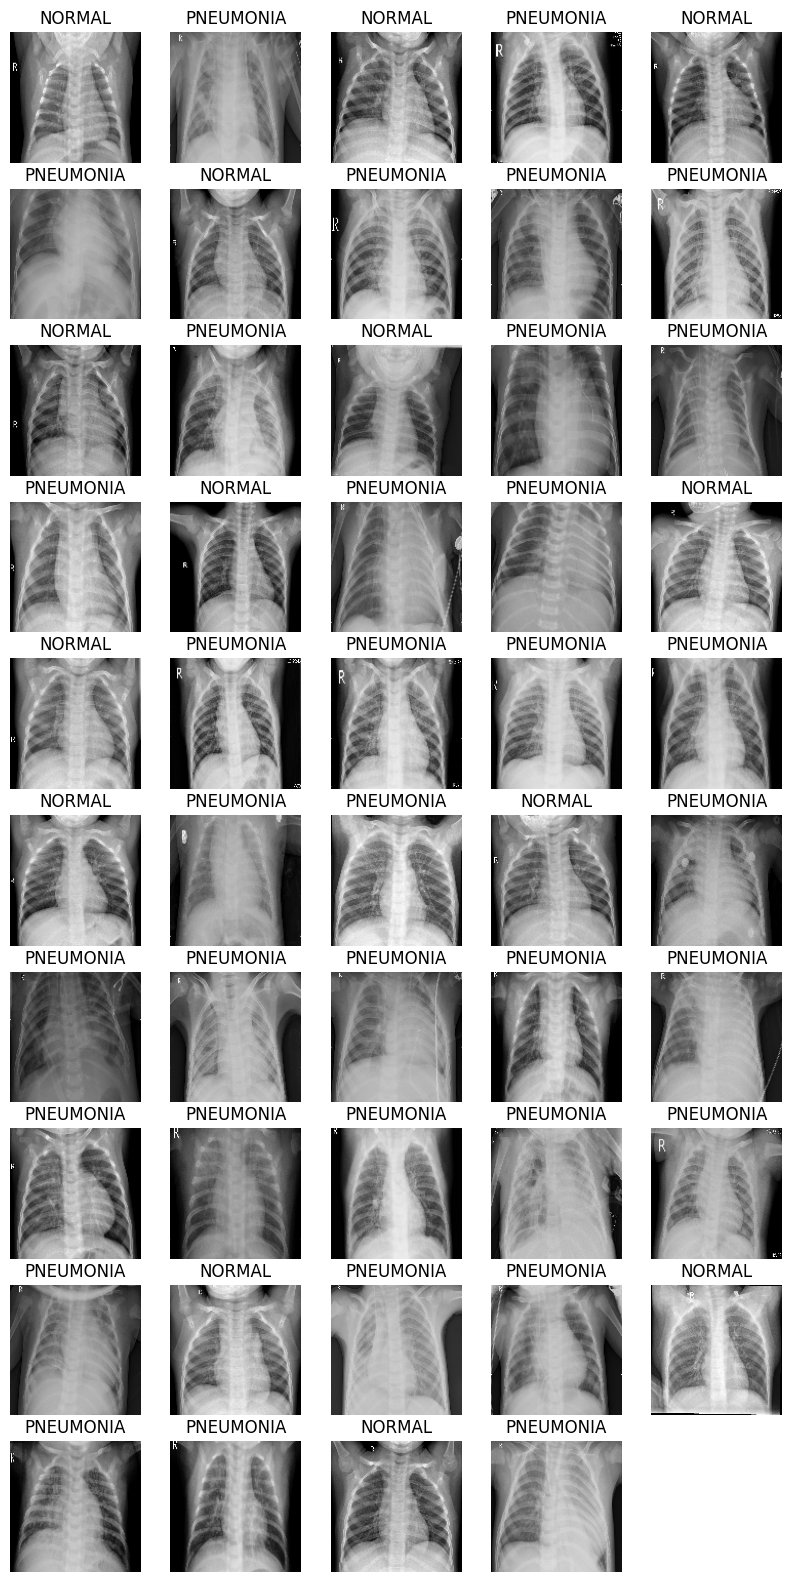

In [120]:

#ranskal
import random
plt.figure(figsize=(10,20))
for i in range(0,49) :
    plt.subplot(10,5,i+1)
    j = random.randint(0,len(X))
    plt.axis('off')
    plt.imshow(X[j])
    plt.title(Classes[y[j]])

In [121]:
X.shape

(3978, 128, 128, 3)

In [122]:
# Normalisation entre 0 et 1
X = X / 255 # X=train_data, y=train_labels
print(X[0][0])

[[0.08627451 0.08627451 0.08627451]
 [0.07843137 0.07843137 0.07843137]
 [0.0627451  0.0627451  0.0627451 ]
 [0.19215686 0.19215686 0.19215686]
 [0.23529412 0.23529412 0.23529412]
 [0.27058824 0.27058824 0.27058824]
 [0.29019608 0.29019608 0.29019608]
 [0.3254902  0.3254902  0.3254902 ]
 [0.35294118 0.35294118 0.35294118]
 [0.35686275 0.35686275 0.35686275]
 [0.37647059 0.37647059 0.37647059]
 [0.39607843 0.39607843 0.39607843]
 [0.38823529 0.38823529 0.38823529]
 [0.40392157 0.40392157 0.40392157]
 [0.41960784 0.41960784 0.41960784]
 [0.43137255 0.43137255 0.43137255]
 [0.41568627 0.41568627 0.41568627]
 [0.6745098  0.6745098  0.6745098 ]
 [0.55686275 0.55686275 0.55686275]
 [0.54509804 0.54509804 0.54509804]
 [0.54117647 0.54117647 0.54117647]
 [0.75686275 0.75686275 0.75686275]
 [0.46666667 0.46666667 0.46666667]
 [0.43529412 0.43529412 0.43529412]
 [0.43921569 0.43921569 0.43921569]
 [0.42745098 0.42745098 0.42745098]
 [0.42352941 0.42352941 0.42352941]
 [0.40392157 0.40392157 0.40

In [123]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

In [16]:
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras.layers import Dense, Dropout, Flatten

from tensorflow.keras.layers import Conv2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical

On décompose en ensemble d'apprentissage et de validation :

In [124]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1) # X=train_data, y=train_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=1) # X=train_data, y=train_labels


In [126]:
del X,y

On va utiliser utiliser une couche convolutionnelle pour l'extraction des caractéristiques, et une couche dense pour la classification :

In [127]:
# Réseau convolutionnel simple
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=(128, 128, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
model.add(Dense(Nombre_classes, activation='softmax'))

# Compilation du modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

u:\Users\ok025980\Kuvat_ja_mallinnus\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


On peut afficher la structure du modèle :

In [128]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │       984,066 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 986,498 (3.76 MB)

 Trainable params: 986,498 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [129]:
# Apprentissage
# train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)
# Treeni ja validointidata kuntoon (Kerttuli)
# train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1)
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, verbose=1)

Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 92ms/step - accuracy: 0.7499 - loss: 2.6682 - val_accuracy: 0.9347 - val_loss: 0.1715
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9563 - loss: 0.1218 - val_accuracy: 0.9447 - val_loss: 0.1404
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9669 - loss: 0.0925 - val_accuracy: 0.9447 - val_loss: 0.1733
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9898 - loss: 0.0354 - val_accuracy: 0.9472 - val_loss: 0.1409
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9916 - loss: 0.0259 - val_accuracy: 0.9447 - val_loss: 0.1845
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9876 - loss: 0.0319 - val_accuracy: 0.9497 - val_loss: 0.1435
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accuracy: 0.9573 - val_loss: 0.1822
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.9955 - loss: 0.0169 - 

In [130]:
# arvioidaan malli testidatalla
 
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Testin tarkkuus: {test_accuracy}")
 

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.7804 - loss: 318.1730
Testin tarkkuus: 0.7817014455795288


In [ ]:
# # Test
# scores = model.evaluate(X_test, y_test, verbose=0)
# print("Score : %.2f%%" % (scores[1]*100))

Score : 93.47%


On définit une fonction pour afficher un graphique des scores :

In [131]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

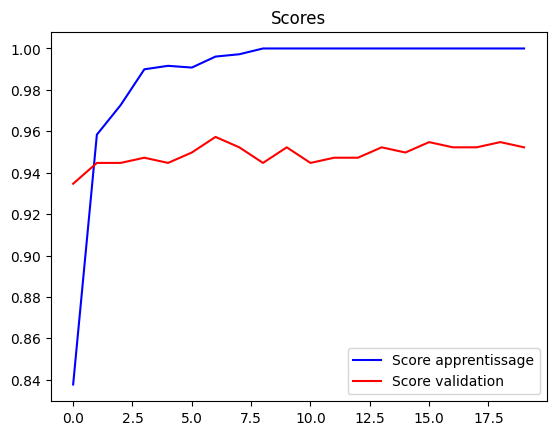

In [132]:
plot_scores(train)

HUOM!!! np.argmax valitsee todennäköisyysarvoista suuremman ja pitää tallella, kummalle arvolle, 1 tai 0, ko arvo kuuluu

In [133]:
import numpy as np
y_pred = np.argmax(model.predict(test_ds), axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


In [143]:
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [140]:
y_pred2 = model.predict(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step


In [141]:
y_pred2.shape

(623, 2)

In [134]:
y_pred.shape


(623,)

In [136]:
print(y_pred[0])

0


In [137]:
print(y_pred)

[0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1
 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(test_ds, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])  # Adjust labels
disp.plot(cmap="Blues")


ValueError: Found input variables with inconsistent numbers of samples: [5, 623]

### Siniset on 

In [104]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score # final metrics
# creating a classification report
cr = classification_report(y_test, y_pred, target_names = ['Normal', 'Pneumonia'])

print(cr)

              precision    recall  f1-score   support

      Normal       0.91      0.88      0.90       128
   Pneumonia       0.95      0.96      0.95       270

    accuracy                           0.93       398
   macro avg       0.93      0.92      0.92       398
weighted avg       0.93      0.93      0.93       398



La pertinence sur l'ensemble d'apprentissage est à 100%, mais ne dépasse pas 97% sur l'ensemble de validation ce qui est déjà un trés bon score.

In [ ]:
# Prediction ---> here the np.argmax selects the greater propability
y_cnn = np.argmax(model.predict(X_test),axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


on affiche 50 images où l'algorithme s'est trompé:

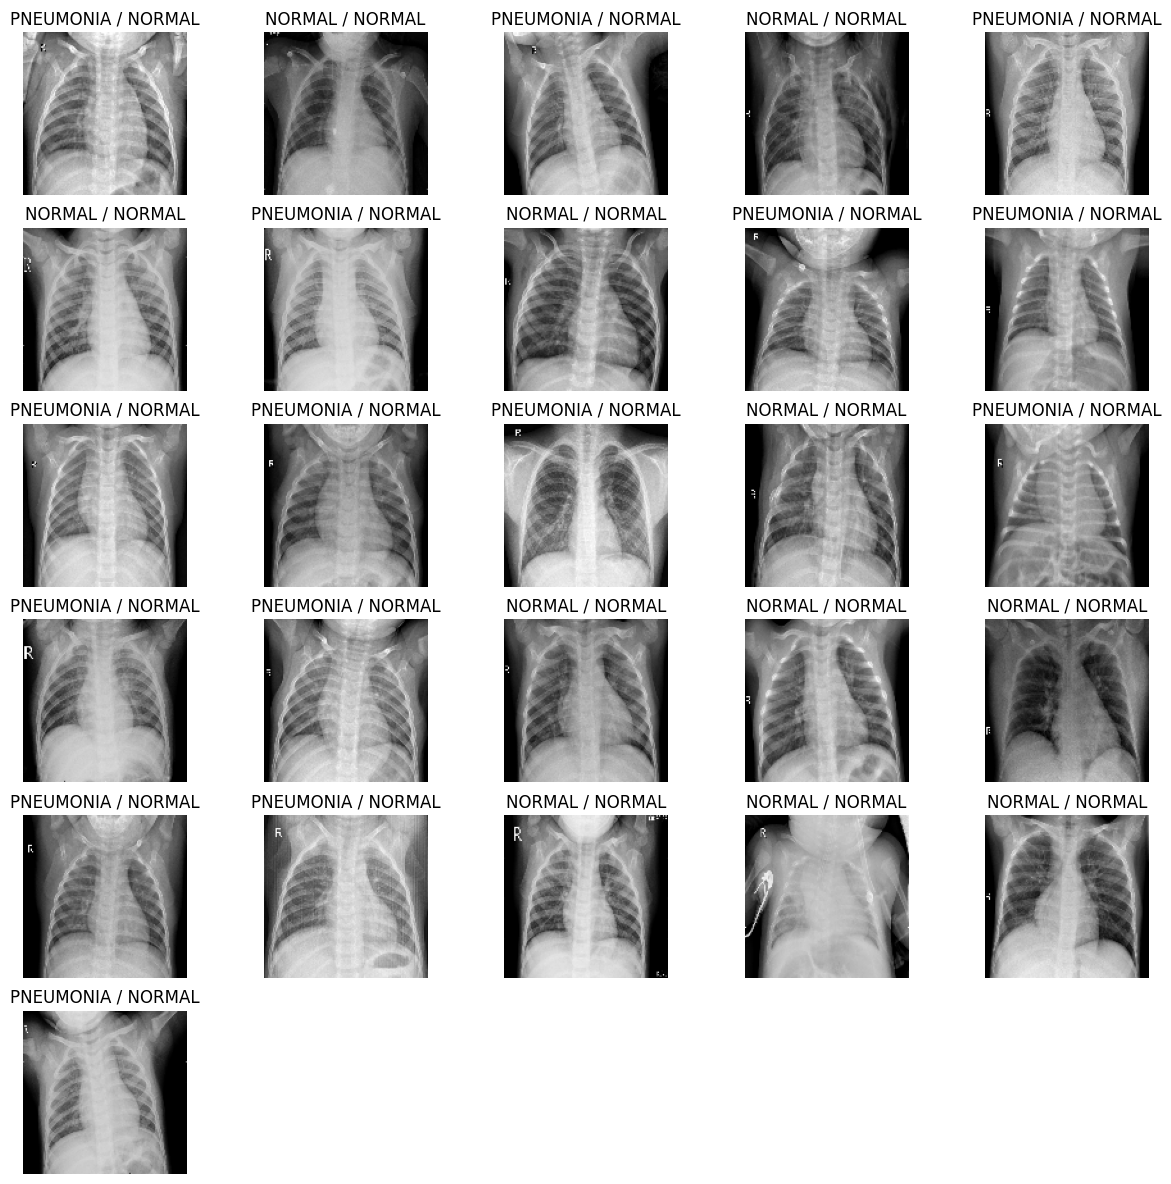

In [29]:
plt.figure(figsize=(15,25))
n_test = X_test.shape[0]
i=1
for j in range(len(X_test)) :
    if (y_cnn[j] != y_test[j]) & (i<50) :
        plt.subplot(10,5,i)
        plt.axis('off')
        plt.imshow(X_test[j])
        plt.title('%s / %s' % (Classes[y_cnn[j]], Classes[y_test[j].argmax(axis=-1)]))
        i+=1

In [95]:
n_test = X_test.shape[0]
i=1
for j in range(len(X_test)) :
    if (y_cnn[j] != y_test[j]) & (i<50) :
        print(f"Index: {j}, y_cnn: {y_cnn[j]}, y_test: {y_test[j].argmax(axis=-1)}, Condition: {y_cnn[j] != y_test[j]}")


Index: 6, y_cnn: 1, y_test: 0, Condition: True
Index: 10, y_cnn: 0, y_test: 0, Condition: True
Index: 46, y_cnn: 1, y_test: 0, Condition: True
Index: 67, y_cnn: 0, y_test: 0, Condition: True
Index: 81, y_cnn: 1, y_test: 0, Condition: True
Index: 87, y_cnn: 0, y_test: 0, Condition: True
Index: 106, y_cnn: 1, y_test: 0, Condition: True
Index: 127, y_cnn: 0, y_test: 0, Condition: True
Index: 148, y_cnn: 1, y_test: 0, Condition: True
Index: 169, y_cnn: 1, y_test: 0, Condition: True
Index: 183, y_cnn: 1, y_test: 0, Condition: True
Index: 224, y_cnn: 1, y_test: 0, Condition: True
Index: 234, y_cnn: 1, y_test: 0, Condition: True
Index: 238, y_cnn: 0, y_test: 0, Condition: True
Index: 251, y_cnn: 1, y_test: 0, Condition: True
Index: 254, y_cnn: 1, y_test: 0, Condition: True
Index: 257, y_cnn: 1, y_test: 0, Condition: True
Index: 266, y_cnn: 0, y_test: 0, Condition: True
Index: 288, y_cnn: 0, y_test: 0, Condition: True
Index: 313, y_cnn: 0, y_test: 0, Condition: True
Index: 330, y_cnn: 1, y_tes

Seulement 6 images ont mal été classifiées.

2 couches convolutionnelles¶

In [96]:
# Modèle CNN plus profond
modelx = Sequential()
modelx.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
modelx.add(MaxPooling2D(pool_size=(2, 2)))
modelx.add(Conv2D(20, (3, 3), activation='relu'))
modelx.add(MaxPooling2D(pool_size=(2, 2)))
modelx.add(Conv2D(20, (3, 3), activation='relu'))
modelx.add(MaxPooling2D(pool_size=(2, 2)))
modelx.add(Dropout(0.2))
modelx.add(Flatten())
modelx.add(Dense(Nombre_classes, activation='softmax'))

# Compilation du modèle
modelx.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

u:\Users\ok025980\Kuvat_ja_mallinnus\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [97]:
modelx.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 20)     │         5,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 20)     │         3,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         7,842 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,138 (70.85 KB)

 Trainable params: 18,138 (70.85 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# # Apprentissage
# train2 = modelx.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=1)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - accuracy: 0.7774 - loss: 0.5108 - val_accuracy: 0.9497 - val_loss: 0.1711
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.9319 - loss: 0.1630 - val_accuracy: 0.9523 - val_loss: 0.1520
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.9597 - loss: 0.1173 - val_accuracy: 0.9523 - val_loss: 0.1487
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9514 - loss: 0.1249 - val_accuracy: 0.9648 - val_loss: 0.1129
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.9676 - loss: 0.0889 - val_accuracy: 0.9598 - val_loss: 0.1255
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9781 - loss: 0.0645 - val_accuracy: 0.9598 - val_loss: 0.1245
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.9691 - loss: 0.0792 - val_accuracy: 0.9598 - val_loss: 0.1051
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.9747 - loss: 0

In [99]:
# Test
scores = modelx.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 97.24%


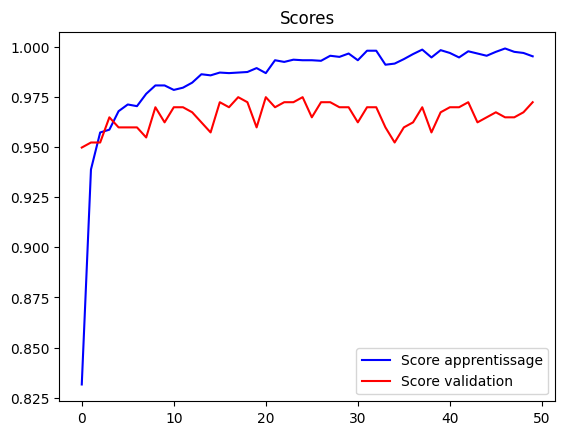

In [100]:
plot_scores(train2)

En conclusion, la deuxième couche de neuronnes n'était pas nécessaire car on obtient des résultats identiques au modèle précédent. Les réseaux convolutifs de neuronnes sont performants pour ce problème

In [101]:
y_predx = np.argmax(modelx.predict(X_test), axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


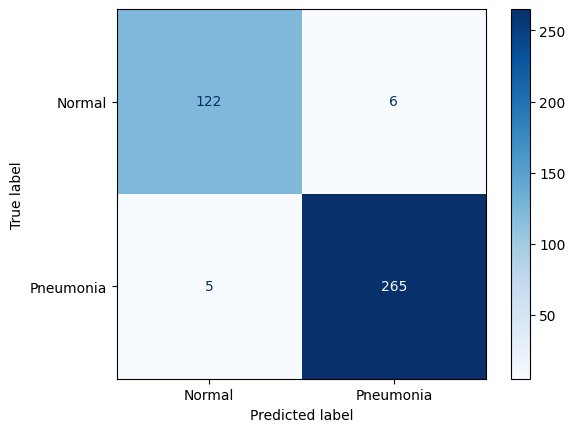

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_predx)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])  # Adjust labels
disp.plot(cmap="Blues")

In [103]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score # final metrics
# creating a classification report
cr = classification_report(y_test, y_predx, target_names = ['Normal', 'Pneumonia'])

print(cr)

              precision    recall  f1-score   support

      Normal       0.96      0.95      0.96       128
   Pneumonia       0.98      0.98      0.98       270

    accuracy                           0.97       398
   macro avg       0.97      0.97      0.97       398
weighted avg       0.97      0.97      0.97       398

